In [39]:
def generate_initial_value():
    import numpy as np
    from scipy.fft import fft, ifft, fftfreq
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation
    from IPython.display import Video
    from time import time as timer

    # --- 1D electrostatic Vlasov-Poisson simulation ---
    def vlasov_simulation(flag_init="linear-Landau"):
        if flag_init == "linear-Landau" or flag_init == "nonlinear-Landau" or flag_init == "bump-on-tail":
            Nx, Nv = 128, 256
            Lx, Lv = 10 * np.pi, 5.0
        elif flag_init == "two-stream":
            Nx, Nv = 128, 256
            Lx, Lv = 100, 9.0
        else:
            raise ValueError(f"Unknown flag_init: {flag_init}")

        dx, dv = Lx / Nx, 2 * Lv / (Nv - 1)
        x = np.linspace(0, Lx, Nx, endpoint=False)
        v = np.linspace(-Lv, Lv, Nv)
        X, V = np.meshgrid(x, v, indexing='xy')

        dt = 0.25
        # nt = 100
        nt = 1
        nskip = 20
        nsave = (nt - 1) // nskip + 1

        kx = fftfreq(Nx, d=dx) * 2 * np.pi
        kv = fftfreq(Nv, d=dv) * 2 * np.pi
        ksq_inv = np.divide(1.0, kx**2, where=(kx != 0.0))
        fmx = np.exp(-0.5 * v**2) / np.sqrt(2 * np.pi)

        # --- Initial conditions ---
        np.random.seed(0)
        if flag_init == "linear-Landau":
            ampl = 1e-3
            f0_v = fmx.copy()
            f = f0_v[:, None] + ampl * np.cos(4 * np.pi * x / Lx)[None, :] * fmx[:, None]

        elif flag_init == "nonlinear-Landau":
            ampl = 0.2
            f0_v = fmx.copy()
            f = f0_v[:, None] + ampl * np.cos(4 * np.pi * x / Lx)[None, :] * fmx[:, None]

        elif flag_init == "bump-on-tail":
            ampl = 1e-3
            nb, vb, vtb = 0.2, 2.0, 0.3
            bump = np.exp(-0.5 * ((v - vb) / vtb)**2) / np.sqrt(2 * np.pi * vtb**2)
            f0_v = (1.0 - nb) * fmx + nb * bump
            f = np.zeros((Nv, Nx))
            rand_phases = np.random.rand(Nx // 4)
            for ik in range(1, Nx // 4):
                phase = 2 * np.pi * rand_phases[ik]
                f += ampl * np.cos(2 * np.pi * (ik * x / Lx + phase))[None, :] * fmx[:, None]
            f += f0_v[:, None]

        elif flag_init == "two-stream":
            ampl = 2e-3
            nb, vb, vtb = 0.5, 3.0, 1.0
            f0b_pos = np.exp(-0.5 * ((v - vb) / vtb)**2) / np.sqrt(2 * np.pi * vtb**2)
            f0b_neg = np.exp(-0.5 * ((v + vb) / vtb)**2) / np.sqrt(2 * np.pi * vtb**2)
            f0_v = (1.0 - nb) * f0b_pos + nb * f0b_neg
            f = np.zeros((Nv, Nx))
            phase1 = 2 * np.pi * np.random.rand(Nx // 4)
            phase2 = 2 * np.pi * np.random.rand(Nx // 4)
            for ik in range(1, Nx // 4):
                f = f + ampl * np.cos(2 * np.pi * (ik * x / Lx + phase1[ik]))[None, :] * f0b_pos[:, None] + ampl * np.cos(2 * np.pi * (ik * x / Lx + phase2[ik]))[None, :] * f0b_neg[:, None]
            f += f0_v[:, None]

        else:
            raise ValueError(f"Unknown flag_init: {flag_init}")

        f0 = f0_v[:, None] # Electron equilibrium distribution f_e0(v)
                          # n_e0 = \int f_e0(v) dv = 1.0 from normalization

        def poisson_solver(f): # - (d/dx)^2 phi = rho
            ne = np.sum(f, axis=0) * dv # Electron density n_e
            rho = 1.0 - ne              # Charge density rho = e(n_i0 - n_e)
            rho_k = fft(rho)
            phi_k = rho_k * ksq_inv
            phi = np.real(ifft(phi_k))  # Electrostatic potential phi
            E_k = -1j * kx * phi_k
            E = np.real(ifft(E_k))      # Electric field E = - d(phi)/dx
            return rho, phi, E

        def time_advance_in_x(f, dt): # Solve df/dt + v * df/dx = 0
            f_hat = fft(f, axis=1)
            phase = np.exp(-1j * kx[None,:] * v[:,None] * dt)
            f_new = np.real(ifft(f_hat * phase, axis=1))
            rho, phi, E = poisson_solver(f_new)
            return f_new, rho, phi, E

        def time_advance_in_v(f, E, dt): # Solve df/dt - E * df/dv = 0
            f_hat = fft(f, axis=0)
            phase = np.exp(+1j * kv[:,None] * E[None,:] * dt)
            f_new = np.real(ifft(f_hat * phase, axis=0))
            return f_new

        t_all, f_all = [], []
        rho_all, phi_all, E_all = [], [], []

        rho, phi, E = poisson_solver(f)
        t=0.0
        # --- Time integration loop ---
        for _ in range(nsave):
            t_all.append(t)
            f_all.append(f.copy())
            rho_all.append(rho.copy())
            phi_all.append(phi.copy())
            E_all.append(E.copy())
            for _ in range(nskip):
                f, rho, phi, E = time_advance_in_x(f, dt / 2)
                f = time_advance_in_v(f, E, dt)
                f, rho, phi, E = time_advance_in_x(f, dt / 2)
                t = t + dt

        t_all = np.array(t_all)
        f_all = np.array(f_all)
        field_all = (np.array(rho_all), np.array(phi_all), np.array(E_all))
        return t_all, f_all, field_all, f0, x, v, Nx, Nv, Lx, Lv

    # --- Run the simulation ---
    elt0 = timer()
    print("Start 1D Vlasov simulation.")
    t_all, f_all, field_all, f0, x, v, Nx, Nv, Lx, Lv = vlasov_simulation(flag_init="two-stream")
    print("Simulation complete.")
    elt1 = timer(); print("Elapsed time [sec] :", elt1 - elt0)
    print(t_all.shape, f_all.shape, x.shape, v.shape)

    return f_all[-1].T, (f[-1].T for f in field_all), Nx, Nv, Lx, Lv

f_init, (rho_init, phi_init, E_init), Nx, Nv, Lx, Lv = generate_initial_value()

Start 1D Vlasov simulation.
Simulation complete.
Elapsed time [sec] : 0.3033578395843506
(1,) (1, 256, 128) (128,) (256,)


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Nx, Nv = 128, 256
# Lx, Lv = 100, 9.0

dx, dv = Lx / Nx, 2 * Lv / (Nv - 1)
x = np.linspace(0, Lx, Nx, endpoint=False)
v = np.linspace(-Lv, Lv, Nv)
print(f"Nx, Nv = {Nx:}, {Nv:}")
print(f"Simple estimation of CFL (v*dfdx): dt < dx/Lx ={dx/Lv:}")

dt = 0.025
nt = 1000
nskip = 20
nsave = (nt - 1) // nskip + 1

kx = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi
kv = np.fft.fftfreq(Nv, d=dv) * 2 * np.pi
ksq_inv = np.divide(1.0, kx**2, out=np.zeros_like(kx), where=(kx != 0.0))
fmx = np.exp(-0.5 * v**2) / np.sqrt(2 * np.pi)

Nx, Nv = 128, 256
Simple estimation of CFL (v*dfdx): dt < dx/Lx =0.08680555555555555


In [46]:
class LowRankApprox:
    """
    Low-rank representation of f(x,v): f(x,v) ≈ X S V^T
        X : (nx, nr)
        S : (nr, nr)
        V : (nv, nr)
        nr : maximum rank
    """
    def __init__(self, nx, nv, nr):
        self.nx = nx
        self.nv = nv
        self.nr = nr
        self.X = np.zeros((nx, nr))
        self.S = np.zeros((nr, nr))
        self.V = np.zeros((nv, nr))

    def init_from_full(self, f):
        """
        Initialize (X,S,V) from full matrix f(x_i, v_j)
        using truncated SVD.
        """
        U, s, Vt = np.linalg.svd(f, full_matrices=False)
        r = min(self.nr, s.size)

        X = U[:, :r]
        S = np.diag(s[:r])
        V = Vt[:r, :].T

        # 重み付き直交化（Ensignと同じ）
        X, Rx = cholesky_qr(X, dx)
        V, Rv = cholesky_qr(V, dv)

        self.X[:, :r] = X
        self.S[:r, :r] = Rx @ S @ Rv.T
        self.V[:, :r] = V

        # zero out unused components
        self.X[:, r:] = 0.0
        self.S[r:, :] = 0.0
        self.S[:, r:] = 0.0
        self.V[:, r:] = 0.0

    def to_full(self, nr_truncate=None):
        if nr_truncate is None:
            nr_truncate = self.nr
        return (
            self.X[:, :nr_truncate]
            @ self.S[:nr_truncate, :nr_truncate]
            @ self.V[:, :nr_truncate].T
        )

    def eval_row(self, ix, nr_truncate=None):
        """
        f(v) at fixed x index ix.
        """
        if nr_truncate is None:
            nr_truncate = self.nr
        coeff = (
            self.X[ix, :nr_truncate]
            @ self.S[:nr_truncate, :nr_truncate]
        )
        return self.V[:, :nr_truncate] @ coeff

    def eval_col(self, iv, nr_truncate=None):
        """
        f(x) at fixed v index iv.
        """
        if nr_truncate is None:
            nr_truncate = self.nr
        coeff = (
            self.V[iv, :nr_truncate]
            @ self.S[:nr_truncate, :nr_truncate].T
        )
        return self.X[:, :nr_truncate] @ coeff

    def copy(self, nr_truncate=None):
        if nr_truncate is None:
            nr_truncate = self.nr
        assert nr_truncate <= self.nr
        new = LowRankApprox(self.nx, self.nv, nr_truncate)
        new.X = self.X[:, :nr_truncate].copy()             # (Nx,Nr)
        new.S = self.S[:nr_truncate, :nr_truncate].copy()  # (Nr,Nr)
        new.V = self.V[:, :nr_truncate].copy()             # (Nv,Nr)
        return new

def solve_poisson_lra(f_lra):
    """
    Solve Poisson equation using low-rank f.
    - d^2 phi / dx^2 = rho
    """
    ne = electron_density_lra(f_lra)  # Electron density n_e
    rho = 1.0 - ne                    # Charge density rho = e(n_i0 - n_e)
    rho_k = np.fft.fft(rho)
    phi_k = rho_k * ksq_inv
    phi = np.real(np.fft.ifft(phi_k)) # Electrostatic potential phi
    E_k = -1j * kx * phi_k
    E = np.real(np.fft.ifft(E_k))     # Electric field E = - d(phi)/dx
    return rho, phi, E

def electron_density_lra(f_lra):
    """
    Compute electron density n_e(x) = ∫ f(x,v) dv = X @ S @ ∫ V(v) dv
    from LowRankApprox without reconstructing full f.
    """
    # ∫ V_s(v) dv
    v_int = np.sum(f_lra.V, axis=0) * dv # (Nr)=int(Nv,Nr)dv

    # c_r = Σ_s S_rs * ∫V_s dv
    coeff = f_lra.S @ v_int # (Nr)=(Nr,Nr)@(Nr)

    # n_e(x) = Σ_r X_r(x) * c_r
    ne = f_lra.X @ coeff # (Nx)=(Nx,Nr)@(Nr)
    return ne

# def cholesky_qr(Q, w):
#     """
#     Ensign::orthogonalize に相当する重み付き直交化（Cholesky-QR）

#     Parameters
#     ----------
#     Q : ndarray, shape (N, r)
#         入力基底（上書きされる想定）
#     w : float or ndarray shape (N,)
#         内積の重み（dx, dv, または非一様重み）

#     Returns
#     -------
#     Q_ortho : ndarray, shape (N, r)
#         w-直交化された基底（Q^T W Q = I）
#     R : ndarray, shape (r, r)
#         上三角行列（S に吸収される）
#     """
#     if np.isscalar(w):
#         # W = w * I
#         G = (Q.T @ Q) * w
#     else:
#         # W = diag(w)
#         G = Q.T @ (Q * w[:, None])

#     # Cholesky: G = R^T R
#     R = np.linalg.cholesky(G)

#     # Q <- Q R^{-1}
#     Q_ortho = Q @ np.linalg.inv(R)

#     return Q_ortho, R

import numba as nb

@nb.njit(fastmath=True)
def cholesky_qr(Q, w):
    N, r = Q.shape
    Qout = Q.copy()
    R = np.zeros((r, r))

    for i in range(r):
        for j in range(i):
            s = 0.0
            for k in range(N):
                s += Qout[k, j] * Qout[k, i] * w
            R[j, i] = s
            for k in range(N):
                Qout[k, i] -= s * Qout[k, j]

        s = 0.0
        for k in range(N):
            s += Qout[k, i] * Qout[k, i] * w
        R[i, i] = np.sqrt(s)

        for k in range(N):
            Qout[k, i] /= R[i, i]

    return Qout, R



def time_step_dlra_1st_split(f_lra, E, dt):
    f_lra = K_step_RK4(f_lra, E, dt) # X and S are updated (K=XS), under fixed V and E
    f_lra = S_step_RK4(f_lra, E, dt) # S is updated, under fixed X, V and E
    f_lra = L_step_RK4(f_lra, E, dt) # V and S are updated (L=VS^T), under fixed X, and E
    rho, phi, E = solve_poisson_lra(f_lra)
    return f_lra, E

def K_step_RK4(f_lra, E, dt):
    X, S, V = f_lra.X, f_lra.S, f_lra.V

    # K = X S
    K = X @ S # (Nx,Nr)=(Nx,Nr)@(Nr,Nr)

    # coefficient matrices
    C1 = (V.T @ (V * v[:, None])) * dv # (Nr,Nr)=(Nr,Nv)@((Nv,Nr)*(Nv,1))
    # dVdv = np.gradient(V, dv, axis=0)
    Nv, Nr = V.shape
    V_ext = np.zeros((Nv + 2, Nr))
    V_ext[1:-1, :] = V   # interior
    dVdv = (V_ext[2:, :] - V_ext[:-2, :]) / (2.0 * dv)
    C2 = (V.T @ dVdv) * dv             # (Nr,Nr)=(Nr,Nv)@(Nv,Nr)

    # RK4 (E could be updated with K, E(t)=E(K(t),V), but E is fixed here.)
    k1 = K_rhs(K, C1, C2, E)
    k2 = K_rhs(K + 0.5*dt*k1, C1, C2, E)
    k3 = K_rhs(K + 0.5*dt*k2, C1, C2, E)
    k4 = K_rhs(K + dt*k3, C1, C2, E)
    K = K + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    # QR to enforce low-rank gauge
    # Q, R = np.linalg.qr(K, mode="reduced")
    Q, R = cholesky_qr(K, dx)
    f_lra.X = Q # (Nx,Nr)
    f_lra.S = R # (Nr,Nr)
    return f_lra

def K_rhs(K, C1, C2, E):
    """
    RHS of K-step equation:

        dK/dt = - (dK/dx) @ C1 + (E * K) @ C2

    Parameters
    ----------
    K  : ndarray, shape (Nx, r)
         K(x) = X(x) @ S
    C1 : ndarray, shape (r, r)
         C^1 coefficient matrix
    C2 : ndarray, shape (r, r)
         C^2 coefficient matrix
    E  : ndarray, shape (Nx,)
         Electric field E(x), frozen during K-step

    Returns
    -------
    dKdt : ndarray, shape (Nx, r)
           Time derivative of K
    """
    # spatial derivative dK/dx: shape (Nx, r)
    dKdx = (-np.roll(K, 2, axis=0) + 8*np.roll(K, 1, axis=0) - 8*np.roll(K, -1, axis=0) + np.roll(K, -2, axis=0)) / (12.0 * dx)
    term_x = - dKdx @ C1             # (Nx, r)
    term_E = (E[:, None] * K) @ C2   # (Nx, r)
    return term_x + term_E

def S_step_RK4(f_lra, E, dt):
    """
    Advance S by one time step using RK4.
    X, V are frozen.
    """
    X, S, V = f_lra.X, f_lra.S, f_lra.V

    # ---------- C matrices (v-space) ----------
    C1 = (V.T @ (V * v[:, None])) * dv  # (Nr,Nr)=(Nr,Nv)@((Nv,Nr)*(Nv,1))
    # dVdv = np.gradient(V, dv, axis=0)
    Nv, Nr = V.shape
    V_ext = np.zeros((Nv + 2, Nr))
    V_ext[1:-1, :] = V   # interior
    dVdv = (V_ext[2:, :] - V_ext[:-2, :]) / (2.0 * dv)
    C2 = (V.T @ dVdv) * dv              # (Nr,Nr)=(Nr,Nv)@(Nv,Nr)

    # ---------- D matrices (x-space) ----------
    D1 = (X.T @ (X * E[:, None])) * dx  # (Nr,Nr)=(Nr,Nx)@((Nx,Nr)*(Nx,1))
    dXdx = (-np.roll(X, 2, axis=0) + 8*np.roll(X, 1, axis=0) - 8*np.roll(X, -1, axis=0) + np.roll(X, -2, axis=0)) / (12.0 * dx)
    D2 = (X.T @ dXdx) * dx              # (Nr,Nr)=(Nr,Nx)@(Nx,Nr)

    # ---------- RK4 ----------
    k1 = S_rhs(S, C1, C2, D1, D2)
    k2 = S_rhs(S + 0.5 * dt * k1, C1, C2, D1, D2)
    k3 = S_rhs(S + 0.5 * dt * k2, C1, C2, D1, D2)
    k4 = S_rhs(S + dt * k3, C1, C2, D1, D2)
    f_lra.S = S + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

    return f_lra

def S_rhs(S, C1, C2, D1, D2):
    """
    Right-hand side of S-step ODE:
        dS/dt = D2 @ S @ C1 - D1 @ S @ C2
    """
    return D2 @ S @ C1 - D1 @ S @ C2

def L_step_RK4(f_lra, E, dt):
    """
    Advance L = V S^T by one time step using RK4.
    X is frozen.
    """
    X, S, V = f_lra.X, f_lra.S, f_lra.V

    # ---- build L = V S^T ----
    L = V @ S.T # (Nv,Nr)

    # ---- D matrices (x-space) ----
    D1 = (X.T @ (X * E[:, None])) * dx  # (Nr,Nr)=(Nr,Nx)@((Nx,Nr)*(Nx,1))
    dXdx = (-np.roll(X, 2, axis=0) + 8*np.roll(X, 1, axis=0) - 8*np.roll(X, -1, axis=0) + np.roll(X, -2, axis=0)) / (12.0 * dx)
    D2 = (X.T @ dXdx) * dx              # (Nr,Nr)=(Nr,Nx)@(Nx,Nr)

    # ---- RK4 ----
    k1 = L_rhs(L, D1, D2)
    k2 = L_rhs(L + 0.5 * dt * k1, D1, D2)
    k3 = L_rhs(L + 0.5 * dt * k2, D1, D2)
    k4 = L_rhs(L + dt * k3, D1, D2)
    L = L + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

    # ---- QR (gauge fixing) ----
    # L = Q R  →  V = Q,  S^T = R
    # Q, R = np.linalg.qr(L, mode="reduced")
    Q, R = cholesky_qr(L, dv)
    f_lra.V = Q    # (Nv,Nr)
    f_lra.S = R.T  # (Nr,Nr) Note that L = V S^T.

    return f_lra

def L_rhs(L, D1, D2):
    """
    RHS of L-step ODE (paper eq. (8)):

        dL/dt = (∂_v L) @ D1 - (v * L) @ D2

    Parameters
    ----------
    L  : ndarray, shape (Nv, r)
    D1 : ndarray, shape (r, r)
    D2 : ndarray, shape (r, r)

    Returns
    -------
    dLdt : ndarray, shape (Nv, r)
    """
    # ∂L/∂v
    # dLdv = np.gradient(L, dv, axis=0)
    Nv, Nr = L.shape
    L_ext = np.zeros((Nv + 2, Nr))
    L_ext[1:-1, :] = L   # interior
    dLdv = (L_ext[2:, :] - L_ext[:-2, :]) / (2.0 * dv)
    term_v = dLdv @ D1
    term_x = (v[:, None] * L) @ D2
    return term_v - term_x

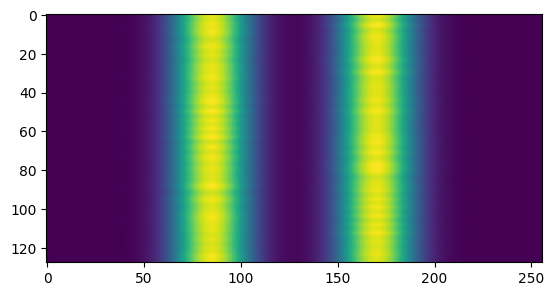

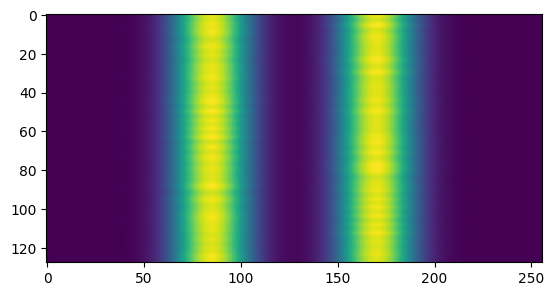

32768 28672


In [47]:
f_lra = LowRankApprox(Nx, Nv, 64)
f_lra.init_from_full(f_init[:,:])

plt.imshow(f_init)
plt.show()
plt.imshow(f_lra.to_full())
plt.show()
print(f_init.size, f_lra.X.size+f_lra.S.size+f_lra.V.size)

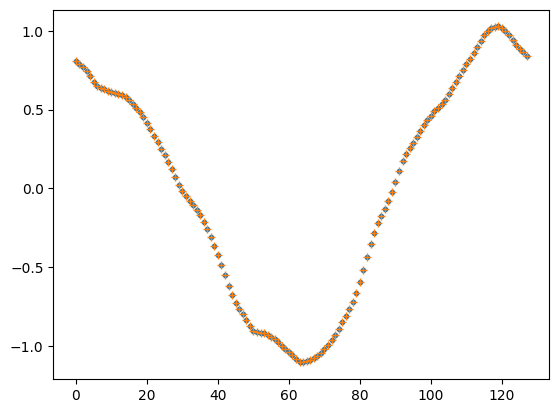

In [48]:
rho, phi, E = solve_poisson_lra(f_lra)

plt.plot(phi_init,".")
plt.plot(phi,"+")
plt.show()

In [49]:
t_all, f_lra_all = [], []
rho_all, phi_all, E_all = [], [], []
t=0.0

# --- Time integration loop ---
for _ in tqdm(range(nsave)):
    rho, phi, E = solve_poisson_lra(f_lra)
    t_all.append(t)
    f_lra_all.append(f_lra.copy())
    rho_all.append(rho.copy())
    phi_all.append(phi.copy())
    E_all.append(E.copy())
    for _ in range(nskip):
        f_lra, E = time_step_dlra_1st_split(f_lra, E, dt)
        t = t + dt

100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


t ≈ 0.00, index = 0


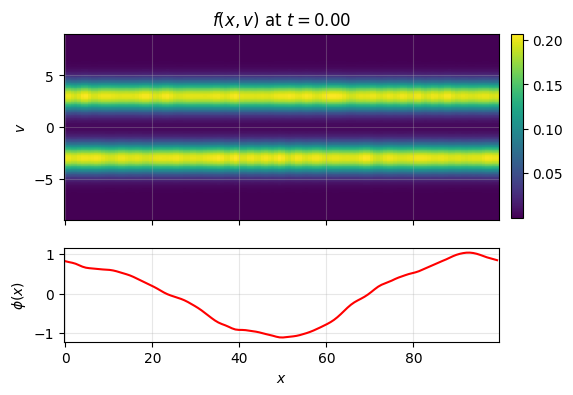

t ≈ 10.00, index = 20


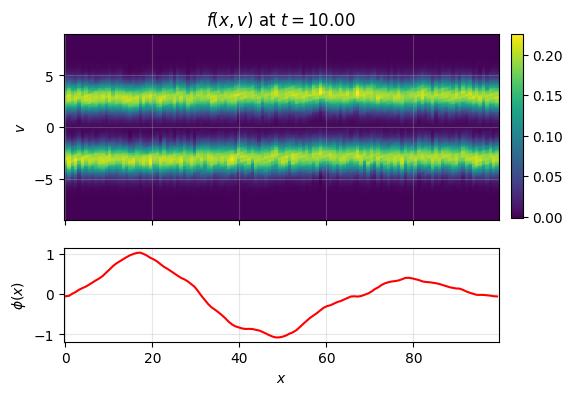

t ≈ 15.00, index = 30


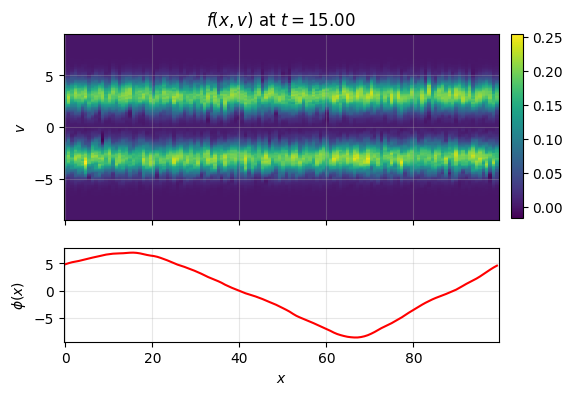

t ≈ 20.00, index = 40


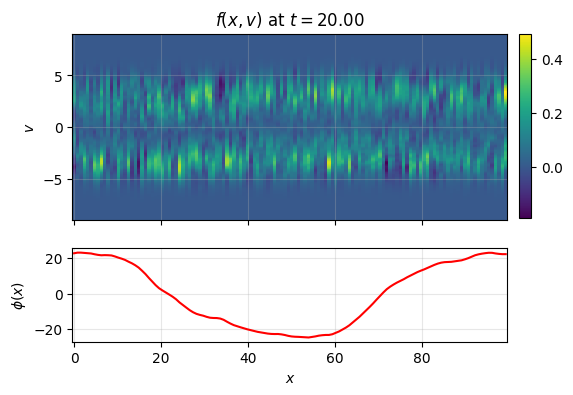

In [50]:
def plot_phase_and_phi(fvx, phi, t, x, v):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True,
                                   gridspec_kw={'height_ratios': [2, 1]})
    plt.subplots_adjust(right=0.85)  # reserve space for colorbar

    pcm = ax1.pcolormesh(x, v, fvx.T, shading='auto', cmap='viridis')
    ax1.set_ylabel(r"$v$")
    ax1.set_title(r"$f(x,v)$ at $t=$"+f"{t:.2f}")
    ax1.grid(True, alpha=0.3)
    cbar_ax = fig.add_axes([0.87, 0.42, 0.02, 0.46])  # [left, bottom, width, height]
    cbar = fig.colorbar(pcm, cax=cbar_ax)

    ax2.plot(x, phi, 'r')
    ax2.set_xlabel(r"$x$")
    ax2.set_ylabel(r"$\phi(x)$")
    ax2.grid(True, alpha=0.3)

    plt.show()

t_all = np.array(t_all)
for t_plot in [0.0, 10.0, 15.0, 20.0]:
    idx = np.argmin(np.abs(t_all - t_plot))
    print(f"t ≈ {t_all[idx]:.2f}, index = {idx}")
    plot_phase_and_phi(f_lra_all[idx].to_full(), phi_all[idx], t_all[idx], x, v)

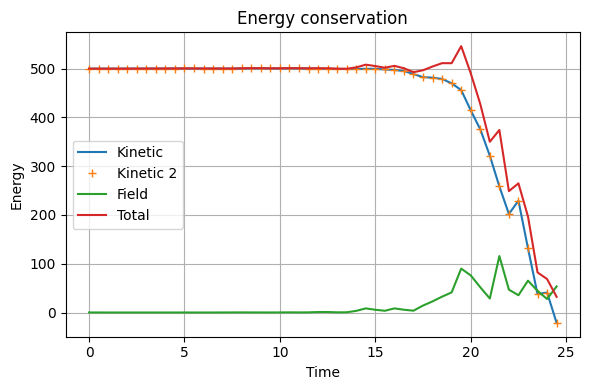

In [51]:
def calc_kinetic_energy_lra(f_lra_all):
    kinetic_energy = []
    for it in range(len(f_lra_all)):
        X = f_lra_all[it].X
        intXdx = np.sum(X,axis=0) * dx
        V = f_lra_all[it].V
        intv2Vdv = np.sum(v[:,None]**2 * V,axis=0) * dv
        S = f_lra_all[it].S
        kinetic_energy.append(0.5 * intXdx @ S @ intv2Vdv)
    return np.array(kinetic_energy)

def calc_kinetic_energy_lra2(f_lra_all):
    kinetic_energy = []
    for it in range(len(f_lra_all)):
        f_all = f_lra_all[it].to_full()
        kinetic_energy.append(0.5 * np.sum(f_all * v[None, :]**2, axis=(0,1)) * dx * dv)
    return np.array(kinetic_energy)

# --- Plot energy conservation ---
kinetic_energy = calc_kinetic_energy_lra(f_lra_all)
kinetic_energy2 = calc_kinetic_energy_lra2(f_lra_all)
field_energy = 0.5 * np.sum(np.array(E_all)**2, axis=1) * dx
total_energy = kinetic_energy + field_energy

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
ax.plot(t_all, kinetic_energy, label="Kinetic")
ax.plot(t_all, kinetic_energy2, "+", label="Kinetic 2")
ax.plot(t_all, field_energy, label="Field")
ax.plot(t_all, total_energy, label="Total")
ax.set_xlabel("Time")
ax.set_ylabel("Energy")
ax.set_title("Energy conservation")
ax.legend()
ax.grid(True)
ax.set_yticks(100*np.arange(6))
plt.tight_layout()
plt.show()

1.000000000000001


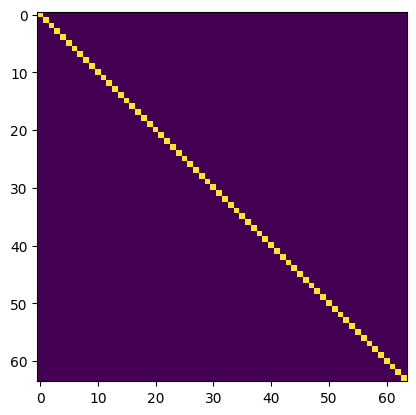

1.0000000000000016


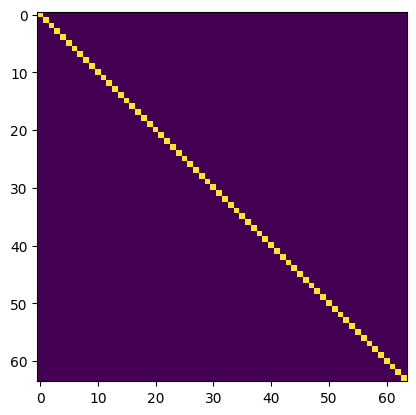

In [52]:
X = f_lra_all[-1].X
orth = X.T @ X * dx
print(orth.max())
plt.imshow(orth)
plt.show()
V = f_lra_all[-1].V
orth = V.T @ V * dv
print(orth.max())
plt.imshow(orth)
plt.show()